In [208]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [209]:
train = pd.read_csv("dataset/train_redu.csv")

test = pd.read_csv("dataset/test_redu.csv")

In [210]:
train.head()

,label,intensidade,simetria
0,0,145.435294,148.572549
1,0,118.576471,137.113725
2,0,127.600000,134.047059
3,0,138.047059,151.003922
4,0,146.215686,122.501961


In [211]:
test.head()

,label,intensidade,simetria
0,0,147.933333,130.470588
1,0,131.054902,122.721569
2,0,134.890196,151.725490
3,0,139.976471,133.921569
4,0,129.580392,130.274510


In [ ]:
def filtrar_digitos(train, test, digito1, digito2):

    selecionados = [digito1, digito2]
    
    train_filtrado = train[train['label'].isin(selecionados)]
    test_filtrado = test[test['label'].isin(selecionados)]
    
    # Resetar índices para evitar problemas depois
    return train_filtrado.reset_index(drop=True), test_filtrado.reset_index(drop=True)

In [215]:
# --- função auxiliar para plot da reta/hyperplano linear ---
def plot_reta_decisao_from_coef(coef, intercepto, color, label):
    # coef: array shape (2,), intercepto: scalar
    x_vals = np.array(plt.gca().get_xlim())
    # x axis is feature 0, y axis is feature 1
    y_vals = -(coef[0] * x_vals + intercepto) / coef[1]
    plt.plot(x_vals, y_vals, color=color, label=label, linewidth=2)



In [216]:
train, test = filtrar_digitos(train, test, 1, 5)


In [217]:
# caso queira salvar os dataframes filtrados

#train1x5.to_csv('train1x5.csv', index=False)
#test1x5.to_csv('test1x5.csv', index=False)

In [218]:
train.head()

,label,intensidade,simetria
0,1,44.701961,69.270588
1,1,59.850980,83.443137
2,1,48.552941,79.043137
3,1,69.435294,72.878431
4,1,51.541176,84.611765


In [219]:
test.head()

,label,intensidade,simetria
0,1,51.639216,71.443137
1,1,51.674510,85.050980
2,1,44.847059,72.674510
3,1,50.760784,81.945098
4,1,57.788235,72.564706


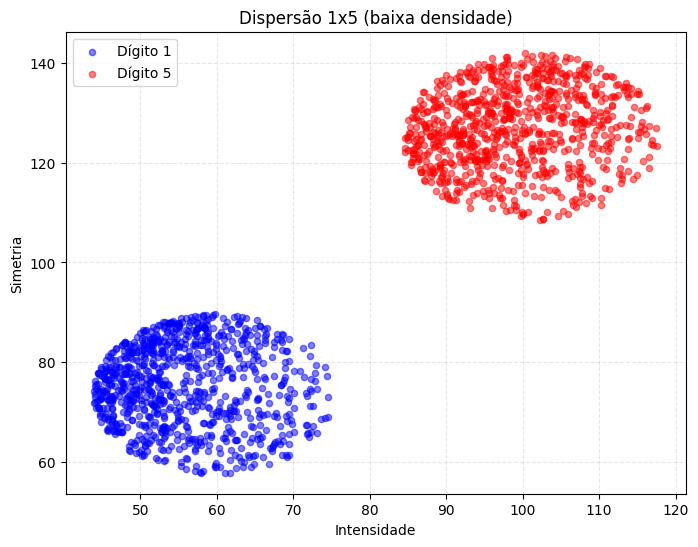

In [220]:
plt.figure(figsize=(8, 6))

# Juntar os dados (opcional, mas deixa o gráfico mais completo e com baixa densidade)
dados_plot = pd.concat([train, test])

# Separar os dígitos
digito1 = dados_plot[dados_plot['label'] == 1]
digito5 = dados_plot[dados_plot['label'] == 5]

# Plotar dígito 1 (azul)
plt.scatter(digito1['intensidade'], digito1['simetria'], 
            color='blue', label='Dígito 1', alpha=0.5, s=20)

# Plotar dígito 5 (vermelho)
plt.scatter(digito5['intensidade'], digito5['simetria'], 
            color='red', label='Dígito 5', alpha=0.5, s=20)

plt.xlabel('Intensidade')
plt.ylabel('Simetria')
plt.title('Dispersão 1x5 (baixa densidade)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [ ]:
#  parâmetros 
digito_positivo = 1
digito_negativo = 5



In [ ]:
#  preparar X e y (treino e teste)
X_train = train[['intensidade', 'simetria']].values
y_train_bin = np.where(train['label'] == digito_positivo, 1, -1)

X_test = test[['intensidade', 'simetria']].values
y_test_bin = np.where(test['label'] == digito_positivo, 1, -1)



In [ ]:
# normalizar (fit apenas no treino) 
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)



In [ ]:
#  treinar modelos (com X normalizado) 
modelo_perc = Perceptron(max_iter=1000, tol=1e-3, random_state=0)
modelo_log = LogisticRegression(max_iter=2000, random_state=0)
modelo_lr = LinearRegression()

modelo_perc.fit(X_train_s, y_train_bin)
modelo_log.fit(X_train_s, y_train_bin)
modelo_lr.fit(X_train_s, y_train_bin)  # LinearRegression aprende valores contínuos



LinearRegression()

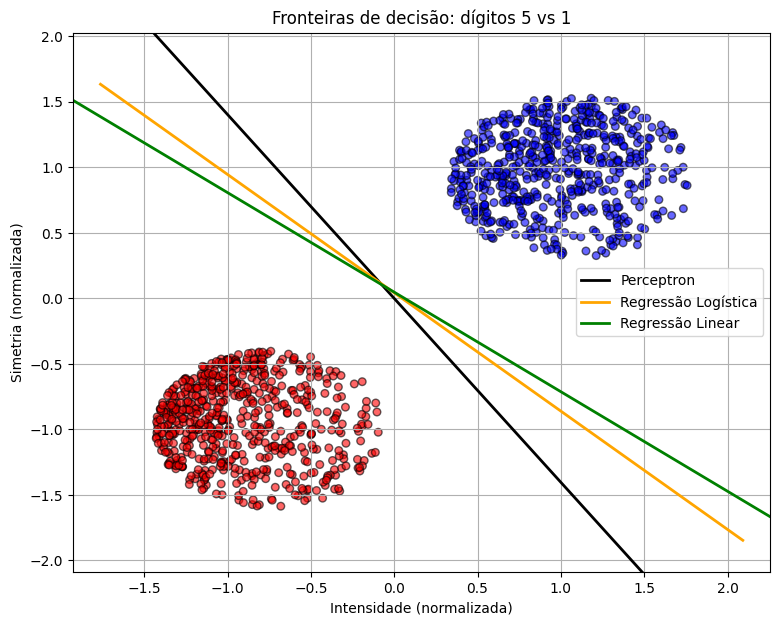

In [ ]:
# plot dos dados e das fronteiras
plt.figure(figsize=(9, 7))

# pontos de treino (normalizados)
plt.scatter(X_train_s[:, 0], X_train_s[:, 1],
            c=['red' if v == 1 else 'blue' for v in y_train_bin],
            edgecolors='k', alpha=0.6, s=30)

# criar mesh no espaço normalizado
pad = 0.5
x_min, x_max = X_train_s[:, 0].min() - pad, X_train_s[:, 0].max() + pad
y_min, y_max = X_train_s[:, 1].min() - pad, X_train_s[:, 1].max() + pad
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]

# cores fixas para cada modelo
cores = {
    "Perceptron": "black",
    "Regressão Linear": "green",
    "Regressão Logística": "orange"
}

# Perceptron
coef_perc = modelo_perc.coef_.ravel()
inter_perc = modelo_perc.intercept_[0]
plot_reta_decisao_from_coef(coef_perc, inter_perc, cores["Perceptron"], "Perceptron")

# Regressão Logística
coef_log = modelo_log.coef_.ravel()
inter_log = modelo_log.intercept_[0]
plot_reta_decisao_from_coef(coef_log, inter_log, cores["Regressão Logística"], "Regressão Logística")

# Regressão Linear: transforma predição contínua em fronteira (nível 0)
# A reta do LinearRegression também pode ser obtida via coef_ e intercept_ (mesmo formato)
coef_lr = modelo_lr.coef_.ravel()
inter_lr = modelo_lr.intercept_
# sklearn LinearRegression pode retornar intercepto como array ou float
if isinstance(inter_lr, np.ndarray):
    inter_lr = float(inter_lr)
plot_reta_decisao_from_coef(coef_lr, inter_lr, cores["Regressão Linear"], "Regressão Linear")

plt.xlabel("Intensidade (normalizada)")
plt.ylabel("Simetria (normalizada)")
plt.title(f"Fronteiras de decisão: dígitos {digito_negativo} vs {digito_positivo}")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.grid(True)
plt.show()



==== Perceptron ====
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



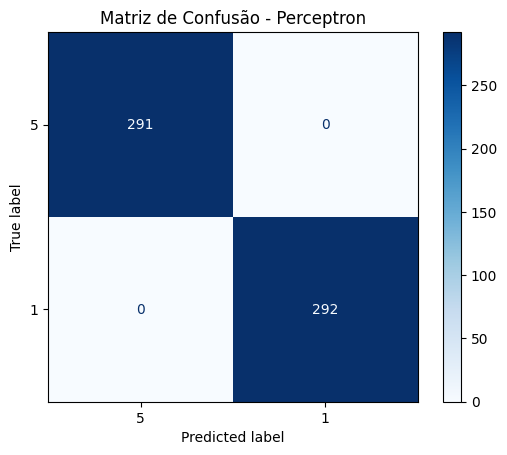


==== Regressão Linear ====
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



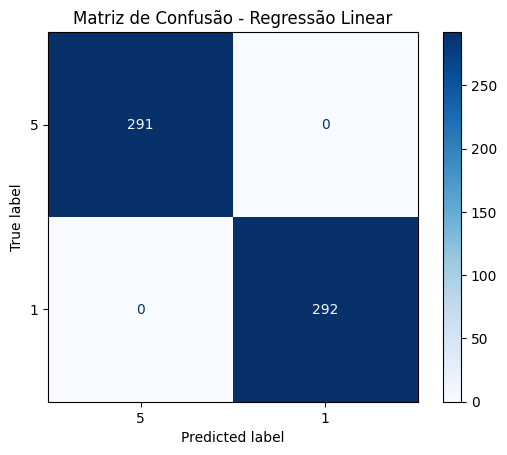


==== Regressão Logística ====
[[291   0]
 [  0 292]]
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



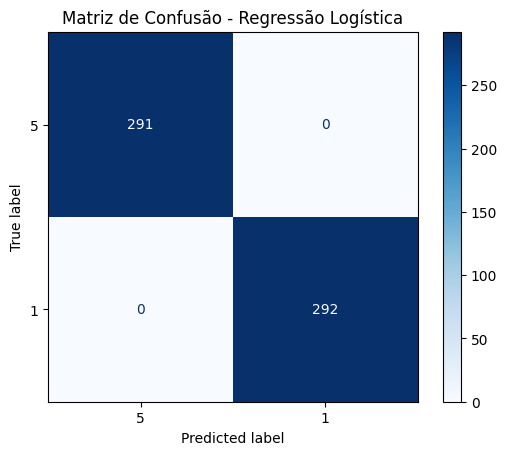

In [ ]:
# Avaliação nos dados de teste (usando X_test_s) 
classificadores = {
    "Perceptron": modelo_perc,
    "Regressão Linear": modelo_lr,
    "Regressão Logística": modelo_log,
}

for nome, modelo in classificadores.items():
    if nome == "Regressão Linear":
        # predição contínua -> threshold em 0
        y_cont = modelo.predict(X_test_s)
        y_pred = np.where(y_cont >= 0, 1, -1)
    else:
        y_pred = modelo.predict(X_test_s)

    cm = confusion_matrix(y_test_bin, y_pred, labels=[-1, 1])
    print(f"\n==== {nome} ====")
    print(cm)
    print(classification_report(y_test_bin, y_pred, target_names=[str(digito_negativo), str(digito_positivo)]))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[digito_negativo, digito_positivo])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()